# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.linear_model import Ridge, LogisticRegression
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Data Prep

In [4]:
data = pd.read_csv('../data/cleaned_data_v2.csv')
drop_cols = ['Unnamed: 0', 'dateload', 'IPC']
data = data.drop(columns=drop_cols)
n= 0.5
data = data.sample(frac=n, random_state=42).dropna()

# Predict Region

In [9]:
def get_us_region(lat, lon):
    # Northeast
    if (36.5 <= lat <= 47.5) and (-82.0 <= lon <= -66.9):
        return "Northeast"
    
    # Midwest
    elif (36.5 <= lat <= 49.0) and (-104.0 <= lon <= -82.0):
        return "Midwest"
    
    # South
    elif (24.5 <= lat <= 36.5) and (-105.0 <= lon <= -75.0):
        return "South"
    
    # West
    elif (31.0 <= lat <= 49.0) and (-125.0 <= lon <= -102.0):
        return "West"
    
    else:
        return "Unknown/Outside U.S."

## Model Setup

In [10]:
usdata = data[data["country"]== "US"]
usdata["region"] = usdata.apply(lambda row: get_us_region(row["lat_appx_lots_of_err"], row["long_appx_lots_of_err"]), axis=1)

X = usdata.drop(columns=['lat_appx_lots_of_err','long_appx_lots_of_err','country', 'region','O score', 'C score', 'E score', 'A score', 'N score' ])
Y = usdata[['region']]
X = X.iloc[:, :-5]

le = LabelEncoder()
y_encoded = le.fit_transform(Y)
# Map encoded values to region names 
print(dict(zip(le.classes_, range(len(le.classes_)))))  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)


/var/folders/m8/cmhpcfhj6qv_4p_mzqsd5p0m0000gn/T/ipykernel_63279/952796556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usdata["region"] = usdata.apply(lambda row: get_us_region(row["lat_appx_lots_of_err"], row["long_appx_lots_of_err"]), axis=1)
/opt/homebrew/Caskroom/miniforge/base/envs/capstone/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Midwest': 0, 'Northeast': 1, 'South': 2, 'Unknown/Outside U.S.': 3, 'West': 4}


## Test Models

In [11]:
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
     "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

Random Forest - MAE: 1.2888, MSE: 2.2899, RMSE: 1.5133, R²: -0.0221
Gradient Boosting - MAE: 1.2729, MSE: 2.2366, RMSE: 1.4955, R²: 0.0017
Decision Tree - MAE: 1.6129, MSE: 4.5504, RMSE: 2.1332, R²: -1.0310
XGBoost - MAE: 1.2777, MSE: 2.3042, RMSE: 1.5180, R²: -0.0285
Linear Regression - MAE: 1.2727, MSE: 2.2377, RMSE: 1.4959, R²: 0.0012


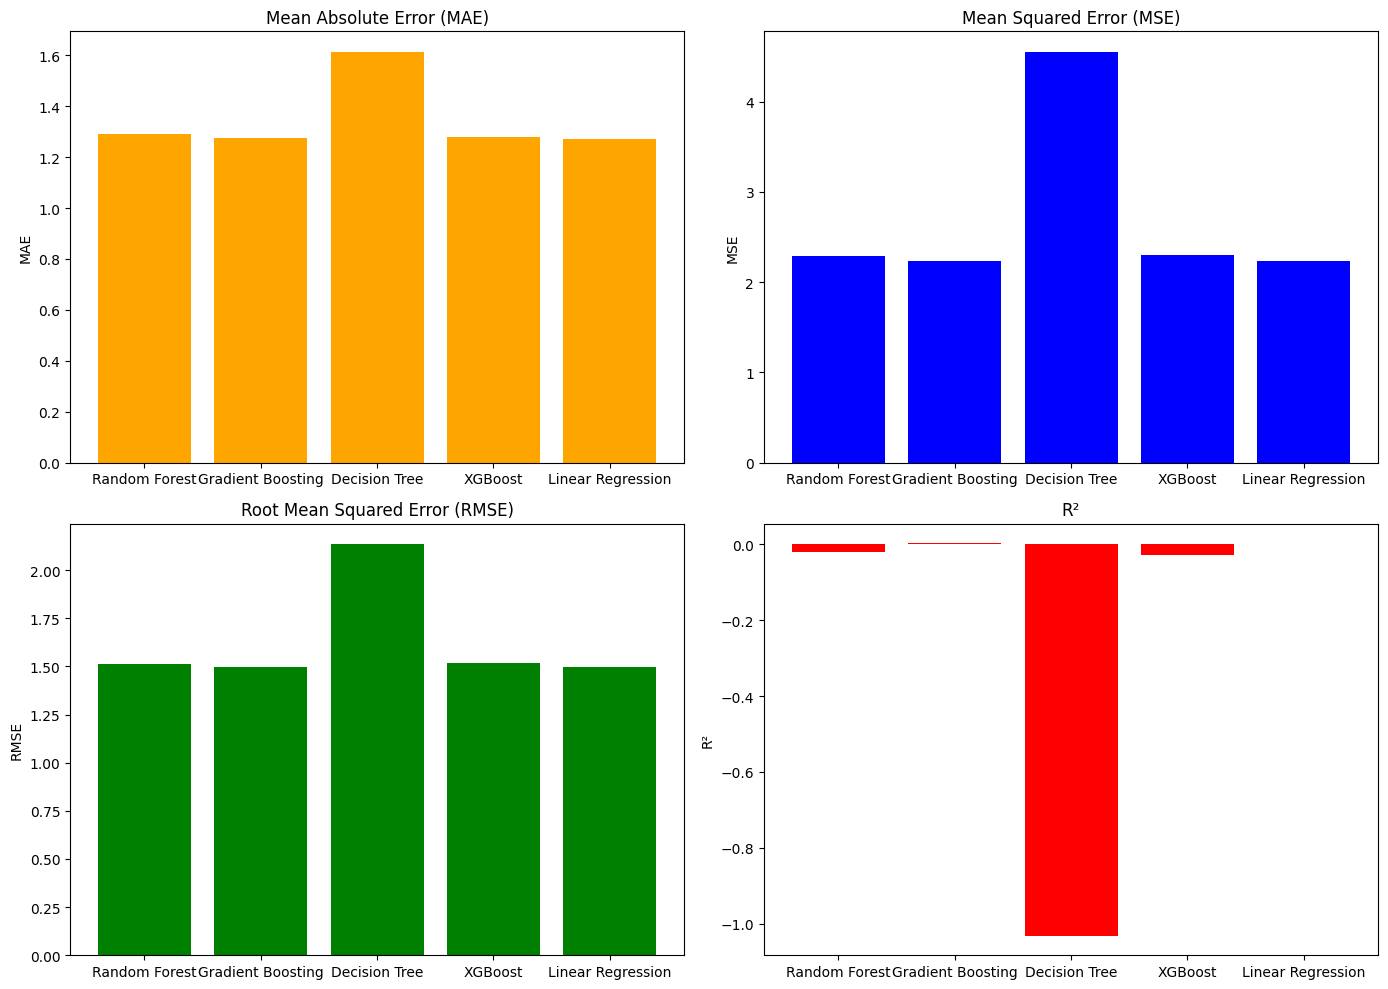

In [12]:


models = ['Random Forest', 'Gradient Boosting', 'Decision Tree', 'XGBoost', 'Linear Regression']

# Metrics
mae = [1.2888, 1.2729, 1.6129, 1.2777, 1.2727]
mse = [2.2899, 2.2366, 4.5504, 2.3042, 2.2377]
rmse = [1.5133, 1.4955, 2.1332, 1.5180, 1.4959]
r2 = [-0.0221, 0.0017, -1.0310, -0.0285, 0.0012]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# MAE
axes[0, 0].bar(models, mae, color='orange')
axes[0, 0].set_title('Mean Absolute Error (MAE)')
axes[0, 0].set_ylabel('MAE')

# MSE
axes[0, 1].bar(models, mse, color='blue')
axes[0, 1].set_title('Mean Squared Error (MSE)')
axes[0, 1].set_ylabel('MSE')

# RMSE
axes[1, 0].bar(models, rmse, color='green')
axes[1, 0].set_title('Root Mean Squared Error (RMSE)')
axes[1, 0].set_ylabel('RMSE')

# R²
axes[1, 1].bar(models, r2, color='red')
axes[1, 1].set_title('R²')
axes[1, 1].set_ylabel('R²')

plt.tight_layout()
plt.show()


# Trait Score Prediction

In [5]:
data['country'] = LabelEncoder().fit_transform(data['country'])
X = data.drop(columns=['O score', 'C score', 'E score', 'A score', 'N score'])
y_scores = data[['O score', 'C score', 'E score', 'A score', 'N score']]

# Train-test split for trait score prediction 
X_train_scores, X_test_scores, y_train_scores, y_test_scores = train_test_split(
    X, y_scores, test_size=0.2, random_state=42
)


selected_features = ["country","introelapse","testelapse","endelapse"]  

X_train_scores= X_train_scores[selected_features]
X_test_scores= X_test_scores[selected_features]

In [6]:
models_regression = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Ridge Regression": Ridge(alpha=1.0)  # Ridge chosen to prevent overfitting
}
results = {}
for trait in y_scores.columns:
    results[trait] = {}
    
    for name, model in models_regression.items():
        model.fit(X_train_scores, y_train_scores[trait])
        y_pred = model.predict(X_test_scores)
        
        mae = mean_absolute_error(y_test_scores[trait], y_pred)
        rmse = np.sqrt(mean_squared_error(y_test_scores[trait], y_pred))
        r2 = r2_score(y_test_scores[trait], y_pred)
        
        results[trait][name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
        print(f"\n{trait} - {name} Performance:")
        print(f"  MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")


O score - Random Forest Performance:
  MAE: 3.1918, RMSE: 4.1608, R²: 0.0124

O score - Ridge Regression Performance:
  MAE: 3.0576, RMSE: 4.1869, R²: -0.0000

C score - Random Forest Performance:
  MAE: 3.2644, RMSE: 4.2672, R²: -0.0324

C score - Ridge Regression Performance:
  MAE: 3.0597, RMSE: 4.1978, R²: 0.0009

E score - Random Forest Performance:
  MAE: 2.8774, RMSE: 3.8123, R²: -0.0220

E score - Ridge Regression Performance:
  MAE: 2.6742, RMSE: 3.7704, R²: 0.0003

A score - Random Forest Performance:
  MAE: 3.0036, RMSE: 3.9674, R²: -0.0038

A score - Ridge Regression Performance:
  MAE: 2.8508, RMSE: 3.9594, R²: 0.0003

N score - Random Forest Performance:
  MAE: 5.6769, RMSE: 7.0305, R²: -0.1174

N score - Ridge Regression Performance:
  MAE: 5.3536, RMSE: 6.6458, R²: 0.0016
